In [2]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam, Adamax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Read the data

In [3]:
# Reading CSV file
train=pd.read_csv("/kaggle/input/emnist/emnist-byclass-train.csv").astype('float32')
train=np.array(train)
test=pd.read_csv("/kaggle/input/emnist/emnist-byclass-test.csv").astype('float32')
test=np.array(test)


#for i in range(33737):
  #train=np.append(train,[test[0]],axis=0)
  #test=np.delete(test,(0),axis=0)


# There are in total 814255 images each of size 28 X 28
# Each row in the CSV file contains one image flattern in a vector of size 784
print("train_data: ")
print()
print(train)

print()
print()

print("test_data: ")
print()
print(test)

train_data: 

[[36.  0.  0. ...  0.  0.  0.]
 [ 6.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  0. ...  0.  0.  0.]
 ...
 [ 5.  0.  0. ...  0.  0.  0.]
 [11.  0.  0. ...  0.  0.  0.]
 [22.  0.  0. ...  0.  0.  0.]]


test_data: 

[[36.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  0. ...  0.  0.  0.]
 ...
 [28.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 5.  0.  0. ...  0.  0.  0.]]


# Shuffling the data

In [4]:
train=shuffle(train)
test=shuffle(test)

# Split the data into image and their labels

In [5]:
# As it is seen that '0' column contains labels (0,61).
# Split data into images and their labels
train_x=train[:,1:785]
train_y=train[:,0]
test_x=test[:,1:785]
test_y=test[:,0]

print("train_x: ", train_x.shape)
print()
print(train_x)
print()

print("test_x",test_x.shape)
print()
print(test_x)
print()

print("train_y",train_y.shape)
print()
print(train_y)
print()

print("test_y",test_y.shape)
print()
print(test_y)
print()

train_x:  (697931, 784)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

test_x (116322, 784)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

train_y (697931,)

[54.  0. 56. ... 27.  1.  5.]

test_y (116322,)

[53.  8. 26. ... 60. 37. 15.]



# Data pre processing
> Reverse and rotate the data

In [6]:
# since the data in emnist by class is rotated and reversed
for i in range(697931):
  image=train_x[i]
  image=np.array(image)
  image=np.reshape(image,(28,28))
  image=np.transpose(image)
  image=image.flatten()
  train_x[i]=image

for i in range(116322):
  image=test_x[i]
  image=np.array(image)
  image=np.reshape(image,(28,28))
  image=np.transpose(image)
  image=image.flatten()
  test_x[i]=image

In [7]:
print(train_x.shape)
print(test_x.shape)

(697931, 784)
(116322, 784)


# Plotting the number of alphabets and digits in the dataset

/tmp/ipykernel_23/2584276745.py:11: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  train_y_integer = np.int0(train_y)
/tmp/ipykernel_23/2584276745.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  test_y_integer = np.int0(test_y)


train_y_integer:  [54  0 56 ... 27  1  5]
test_y_integer:  [53  8 26 ... 60 37 15]


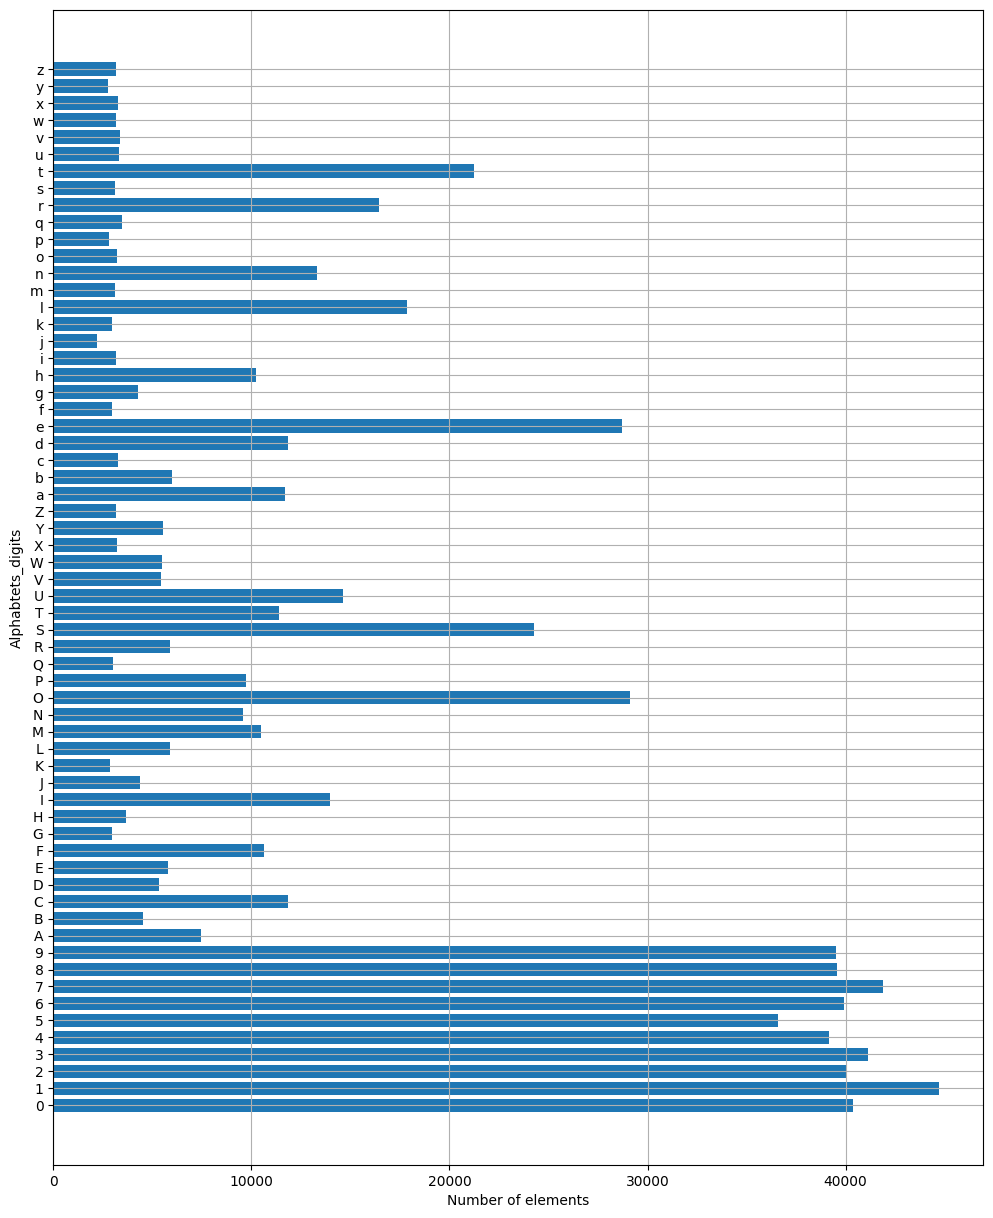

In [8]:
# We create a dictionary word_dict to map the integer values with the characters.
word_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
             16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N', 24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'c',39:'d',40:'e',41:'f',42:'g',43:'h',44:'i',45:'j',
             46:'k',47:'l',48:'m',49:'n', 50:'o',51:'p',52:'q',53:'r',54:'s',55:'t',56:'u',57:'v',58:'w',59:'x',60:'y',
             61:'z'}


# All the labels are present in the form of floating point values, that we convert to integer values.
# y_integer is a vector of 'integer values of y'
train_y_integer = np.int0(train_y)
test_y_integer = np.int0(test_y)
print("train_y_integer: ", train_y_integer)
print("test_y_integer: ", test_y_integer)


# 'count' is vector of size 26 which keeps count of how many times is that character present in dataset
count = np.zeros(62, dtype='int')
for i in train_y_integer:
    count[i] +=1
for i in test_y_integer:
    count[i] +=1

alphabets_digits = ['0','1','2','3','4','5','6','7','8','9',
                    'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


# Plotting the number of each alphabet in the dataset
fig, ax = plt.subplots(1,1, figsize=(12,15))
ax.barh(alphabets_digits, count)   #  'barh' is used to make a horizontal bar plot
plt.xlabel("Number of elements")
plt.ylabel("Alphabtets_digits")
plt.grid()
plt.show()

# Reshaping the Train and Test data

In [11]:
from tensorflow.keras.utils import to_categorical

# Reshaping the training & test DATA so that it can be put in the model
final_train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
print("New shape of train data: ", final_train_x.shape)

final_test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
print("New shape of train data: ", final_test_x.shape)
print()


# Reshaping the training & test LABELS so that it can be put in the model
   # to_categorial converts a class vector(integers) to binary class matrix
   # a = to_categorical([0, 1, 1, 3, 2], num_classes=4)
   # print(a)
   # [[1. 0. 0. 0.]
   # [0. 1. 0. 0.]
   # [0. 1. 0. 0.]
   # [0. 0. 0. 1.]
   # [0. 0. 1. 0.]]
final_train_y = to_categorical(train_y, num_classes = 62)  # numclass=62 because labels have values from 0 to 61 only
print("New shape of train labels: ", final_train_y.shape)

final_test_y = to_categorical(test_y, num_classes = 62)    # numclass=62 because labels have values from 0 to 61 only
print("New shape of test labels: ", final_test_y.shape)

New shape of train data:  (697931, 28, 28, 1)
New shape of train data:  (116322, 28, 28, 1)

New shape of train labels:  (697931, 62)
New shape of test labels:  (116322, 62)


# CNN Model

In [12]:
# CNN model designed for training the model over the training dataset
model = Sequential()


# filters: filter consist of kernels
# activation: activation function to use
#             activation = relu (rectified linear activation function) 
#                          that will output the input directly if it is positive, otherwise, it will output zero.
# padding: one of "valid" or "same"  
#          valid: means no padding. 
#          same: results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width as the input.
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))


model.add(Flatten())


# Fully connected layers
model.add(Dense(256,activation ="relu"))
model.add(Dense(512,activation ="relu"))

# Dropout layer
model.add(Dropout(0.5))

# Softmax function for classification
model.add(Dense(62,activation ="softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling & Fitting the model

In [13]:
# Compiling and fitting the model
model.compile(optimizer = Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(final_train_x, final_train_y, epochs=2,  validation_data = (final_test_x,final_test_y))

Epoch 1/2


I0000 00:00:1734501745.757812     123 service.cc:145] XLA service 0x7ad620001df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734501745.757868     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734501745.757873     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   46/21811 ━━━━━━━━━━━━━━━━━━━━ 1:15 3ms/step - accuracy: 0.0265 - loss: 14.8143     

I0000 00:00:1734501751.516229     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21811/21811 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step - accuracy: 0.6268 - loss: 1.5590 - val_accuracy: 0.8429 - val_loss: 0.4600
Epoch 2/2
21811/21811 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.8273 - loss: 0.5212 - val_accuracy: 0.8552 - val_loss: 0.4068


# Model summary

In [14]:
model.summary()
model.save(r'HCR_English.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,226,556 (12.31 MB)

 Trainable params: 1,075,518 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,151,038 (8.21 MB)

# Model accuracy and Model loss

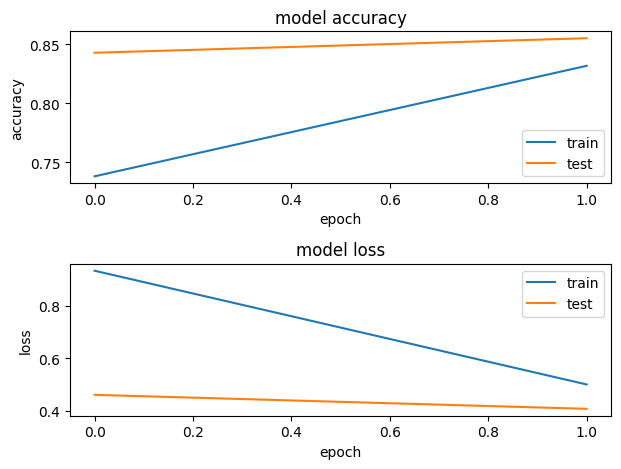

In [15]:
# Plot accuracy vs epoch
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

# Plot loss vs epoch
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

# Prediction on own data
Download the model and test !